# Notebook Imports


In [106]:
from os import walk
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud
from bs4 import BeautifulSoup
from PIL import Image

from sklearn.model_selection import train_test_split

%matplotlib inline

# Constants

In [256]:
EXAMPLE_PATH='SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH='SpamData/01_Processing/spam_assassin_corpus/spam_1/'
SPAM_2_PATH='SpamData/01_Processing/spam_assassin_corpus/spam_2/'
EASY_NONSPAM_1_PATH='SpamData/01_Processing/spam_assassin_corpus/easy_ham_1/'
EASY_NONSPAM_2_PATH='SpamData/01_Processing/spam_assassin_corpus/easy_ham_2/'

SPAM_CAT=1
HAM_CAT=0
VOCAB_SIZE=2500

DATA_JSON_FILE='SpamData/01_Processing/email-text-data.txt'
WORD_ID_FILE='SpamData/01_Processing/word-by-id.csv'

TRAINING_DATA_FILE='SpamData/02_Training/train-data-bidon.txt'
TESTING_DATA_FILE='SpamData/03_Testing/test-data-bidon.txt'

WHALE_FILE='SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE='SpamData/01_Processing/wordcloud_resources/skull-icon.png'

HAM_ICON='SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
SPAM_ICON='SpamData/01_Processing/wordcloud_resources/thumbs-down.png'

# Reading Files

In [108]:
stream=open(EXAMPLE_PATH,encoding='latin-1')
msg=stream.read()
stream.close()

print(msg)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [109]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [110]:
stream=open(EXAMPLE_PATH,encoding='latin-1')

is_body=False
lines=[]

for line in stream:
    if is_body:
        lines.append(line)
    elif line=='\n':
        is_body=True

stream.close()

email_body='\n'.join(lines)
print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Generator Functions

In [111]:
def generate_squares(N):
    for i in range(N):
        yield i**2

In [112]:
for i in generate_squares(5):
    print(i,end='->')

0->1->4->9->16->

## Email body extraction

In [113]:

def email_body_gen(path):
    for root,dirnames,filenames in walk(path):
        for file_name in filenames:
            
            filepath=join(root,file_name)
            
            stream=open(filepath,encoding='latin-1')

            is_body=False
            lines=[]

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line=='\n':
                    is_body=True

            stream.close()

            email_body='\n'.join(lines)
                        
            yield file_name,email_body

        

In [114]:
def df_from_dir(path,classification):
    rows=[]
    row_names=[]
    
    for file_name,email_body in email_body_gen(path):
        rows.append({'MESSAGE':email_body,'CATEGORY':classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows,index=row_names)
        
    

In [115]:
spam_emails=df_from_dir(SPAM_1_PATH,1)
spam_emails=spam_emails.append(df_from_dir(SPAM_2_PATH,1))
spam_emails.head()

,MESSAGE,CATEGORY
00429.0061e48e64f9ce93ffae69bba9151357,Our delightful garden ornaments combine the fi...,1
00447.bd5eb01e94f6d127465bf325513b2516,We guarantee you signups before you ever pay\n...,1
00089.7e7baae6ef4a8fb945d7b3fe551329fe,Email marketing works! There's no way around ...,1
00057.0a2e17bde9485e999ac2259df38528e2,Lowest rates available for term life insurance...,1
00361.e91ac048b0ede961d3f51009eee1c620,OFFICE OF:EGNR. FEMI DANIEL\n\nFEDERAL MINISTR...,1


In [116]:
spam_emails.shape

(1898, 2)

In [117]:
ham_emails=df_from_dir(EASY_NONSPAM_1_PATH,HAM_CAT)
ham_emails=ham_emails.append(df_from_dir(EASY_NONSPAM_2_PATH,HAM_CAT))

In [118]:
ham_emails.shape

(3901, 2)

In [119]:
data=pd.concat([spam_emails,ham_emails])
print('Shape of entire dataframe: ',data.shape)

Shape of entire dataframe:  (5799, 2)


## Data cleaning check missing val

In [120]:
data.MESSAGE

00429.0061e48e64f9ce93ffae69bba9151357    Our delightful garden ornaments combine the fi...
00447.bd5eb01e94f6d127465bf325513b2516    We guarantee you signups before you ever pay\n...
00089.7e7baae6ef4a8fb945d7b3fe551329fe    Email marketing works!  There's no way around ...
00057.0a2e17bde9485e999ac2259df38528e2    Lowest rates available for term life insurance...
00361.e91ac048b0ede961d3f51009eee1c620    OFFICE OF:EGNR. FEMI DANIEL\n\nFEDERAL MINISTR...
                                                                ...                        
00425.1af406dc2ac12d1d5140a6ee5fb75231    > Anyone know where in Ireland I can get a rep...
00281.8166d0f6c6bd6eb4ab1a9730ffbdf383    kevin lyda wrote:\n\n> speaking of things cons...
00351.e08898f91941c9c27c93c339054148de    Quoting Nick Murtagh (nickm@go2.ie):\n\n\n\n> ...
01042.7cf9c2664d2666e767db7b5bec055911    Robert Harley writes:\n\n> Here are some numbe...
00446.d8f63fcbc175d67473d8ca70f4884399     I've a solaris box & a windows 2000 b

In [121]:
data['MESSAGE'].isnull().values

array([False, False, False, ..., False, False, False])

In [122]:
data['MESSAGE'].isnull().values.any()

False

In [123]:
(data.MESSAGE.str.len()==0).any()

True

In [124]:
data[(data.MESSAGE.str.len()==0)]

,MESSAGE,CATEGORY
cmds,,1
cmds,,1
cmds,,0


In [125]:
(data.MESSAGE.str.len()==0).sum()

3

In [126]:
data.MESSAGE.isnull().sum()

0

# Locate empty cell

In [127]:
data[(data.MESSAGE.str.len()==0)].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [128]:
data.index.get_loc('cmds')

array([False, False, False, ..., False, False, False])

# remove sys file entries from dataframe

In [129]:
data.drop(['cmds'],inplace=True)

In [130]:
(data.MESSAGE.str.len()==0).sum()

0

In [131]:
data.shape

(5796, 2)

In [132]:
data.head()

,MESSAGE,CATEGORY
00429.0061e48e64f9ce93ffae69bba9151357,Our delightful garden ornaments combine the fi...,1
00447.bd5eb01e94f6d127465bf325513b2516,We guarantee you signups before you ever pay\n...,1
00089.7e7baae6ef4a8fb945d7b3fe551329fe,Email marketing works! There's no way around ...,1
00057.0a2e17bde9485e999ac2259df38528e2,Lowest rates available for term life insurance...,1
00361.e91ac048b0ede961d3f51009eee1c620,OFFICE OF:EGNR. FEMI DANIEL\n\nFEDERAL MINISTR...,1


# Add doc ID

In [133]:
len(data)

5796

In [134]:
len(data.index)

5796

In [135]:
doc_ids=range(0,len(data))

In [136]:
doc_ids

range(0, 5796)

In [137]:
data['DOC_ID']=doc_ids

In [138]:
data.DOC_ID

00429.0061e48e64f9ce93ffae69bba9151357       0
00447.bd5eb01e94f6d127465bf325513b2516       1
00089.7e7baae6ef4a8fb945d7b3fe551329fe       2
00057.0a2e17bde9485e999ac2259df38528e2       3
00361.e91ac048b0ede961d3f51009eee1c620       4
                                          ... 
00425.1af406dc2ac12d1d5140a6ee5fb75231    5791
00281.8166d0f6c6bd6eb4ab1a9730ffbdf383    5792
00351.e08898f91941c9c27c93c339054148de    5793
01042.7cf9c2664d2666e767db7b5bec055911    5794
00446.d8f63fcbc175d67473d8ca70f4884399    5795
Name: DOC_ID, Length: 5796, dtype: int64

In [139]:
data.head()

,MESSAGE,CATEGORY,DOC_ID
00429.0061e48e64f9ce93ffae69bba9151357,Our delightful garden ornaments combine the fi...,1,0
00447.bd5eb01e94f6d127465bf325513b2516,We guarantee you signups before you ever pay\n...,1,1
00089.7e7baae6ef4a8fb945d7b3fe551329fe,Email marketing works! There's no way around ...,1,2
00057.0a2e17bde9485e999ac2259df38528e2,Lowest rates available for term life insurance...,1,3
00361.e91ac048b0ede961d3f51009eee1c620,OFFICE OF:EGNR. FEMI DANIEL\n\nFEDERAL MINISTR...,1,4


In [140]:
data['FILE_NAME']=data.index

In [141]:
data.head()

,MESSAGE,CATEGORY,DOC_ID,FILE_NAME
00429.0061e48e64f9ce93ffae69bba9151357,Our delightful garden ornaments combine the fi...,1,0,00429.0061e48e64f9ce93ffae69bba9151357
00447.bd5eb01e94f6d127465bf325513b2516,We guarantee you signups before you ever pay\n...,1,1,00447.bd5eb01e94f6d127465bf325513b2516
00089.7e7baae6ef4a8fb945d7b3fe551329fe,Email marketing works! There's no way around ...,1,2,00089.7e7baae6ef4a8fb945d7b3fe551329fe
00057.0a2e17bde9485e999ac2259df38528e2,Lowest rates available for term life insurance...,1,3,00057.0a2e17bde9485e999ac2259df38528e2
00361.e91ac048b0ede961d3f51009eee1c620,OFFICE OF:EGNR. FEMI DANIEL\n\nFEDERAL MINISTR...,1,4,00361.e91ac048b0ede961d3f51009eee1c620


In [142]:
 data.set_index('DOC_ID',inplace=True)

In [143]:
data.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
           dtype='int64', name='DOC_ID', length=5796)

In [144]:
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,Our delightful garden ornaments combine the fi...,1,00429.0061e48e64f9ce93ffae69bba9151357
1,We guarantee you signups before you ever pay\n...,1,00447.bd5eb01e94f6d127465bf325513b2516
2,Email marketing works! There's no way around ...,1,00089.7e7baae6ef4a8fb945d7b3fe551329fe
3,Lowest rates available for term life insurance...,1,00057.0a2e17bde9485e999ac2259df38528e2
4,OFFICE OF:EGNR. FEMI DANIEL\n\nFEDERAL MINISTR...,1,00361.e91ac048b0ede961d3f51009eee1c620


In [145]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5791,> Anyone know where in Ireland I can get a rep...,0,00425.1af406dc2ac12d1d5140a6ee5fb75231
5792,kevin lyda wrote:\n\n> speaking of things cons...,0,00281.8166d0f6c6bd6eb4ab1a9730ffbdf383
5793,Quoting Nick Murtagh (nickm@go2.ie):\n\n\n\n> ...,0,00351.e08898f91941c9c27c93c339054148de
5794,Robert Harley writes:\n\n> Here are some numbe...,0,01042.7cf9c2664d2666e767db7b5bec055911
5795,"I've a solaris box & a windows 2000 box, both...",0,00446.d8f63fcbc175d67473d8ca70f4884399


# Save to file using pandas

In [146]:
data.to_json(DATA_JSON_FILE)  #16

# Visulization 

In [147]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [148]:
amount_of_spam=data.CATEGORY.value_counts()[1]
amount_of_ham=data.CATEGORY.value_counts()[0]

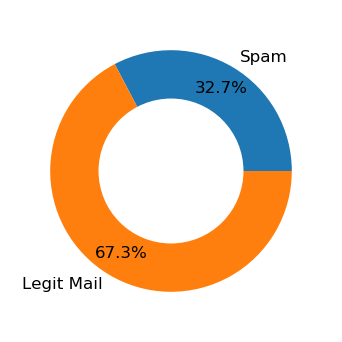

In [149]:
category_name=['Spam','Legit Mail']
sizes=[amount_of_spam,amount_of_ham]

plt.figure(figsize=(2,2),dpi=200)
plt.pie(sizes,labels=category_name,textprops={'fontsize':6},autopct='%1.1f%%',pctdistance=0.8)

centre_circle=plt.Circle((0,0),radius=0.6,fc='white')
plt.gca().add_artist(centre_circle) #gca- get current axis

plt.show()

# NLP
## Text Preprocessing

In [150]:
#Convert to lower cse
msg='All work and no play makes Jack a dull boy.'
msg.lower()

'all work and no play makes jack a dull boy.'

## Download NLTK resources( Tokenizer and stopwords)

In [151]:
nltk.download('punkt')

[nltk_data] Error loading punkt: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>


False

In [152]:
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>


False

In [153]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Error loading gutenberg: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>
[nltk_data] Error loading shakespeare: <urlopen error [Errno -2] Name
[nltk_data]     or service not known>


False

In [154]:
#Tokenising
msg='All work and no play makes Jack a dull boy.'
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy', '.']

In [155]:
#Removing stopwords
stop_words=set(stopwords.words('english'))

In [156]:
type(stop_words)

set

In [157]:
 msg='All work and no play makes Jack a dull boy. To be or not to be. \
 Nobody expects the Spanish Inquisition!'
words=word_tokenize(msg.lower())

stemmer=PorterStemmer()

filter_word=[]
for word in words:
    if word not in stop_words and word.isalpha():  #Remove punctuation
        stemmed_word=stemmer.stem(word)
        filter_word.append(stemmed_word)
print(filter_word)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


In [158]:
'po'.isalpha()

True

In [159]:
'p!'.isalpha()

False

In [160]:
#Removinf HTML tags

soup=BeautifulSoup(data.at[6,'MESSAGE'],'html.parser')
print(soup.prettify)


<bound method Tag.prettify of <html>
<table border="0" bordercolor="#111111" cellpadding="0" cellspacing="1" id="AutoNumber2" style="BORDER-COLLAPSE: collapse" width="715">
<tbody>
<tr>
<td valign="top" width="27"><a href="http://www.frugaljoe.com"><img border="0" src="http://www.frugaljoe.com/logo.jpg"/></a></td>
<td bgcolor="#ffcc99" width="1"><img border="0" height="1" src="http://www.salealerts.com/dot.gif" width="1"/></td>
<td valign="top"><i><b><font face="Verdana" size="2">
<center>Never Pay Retail!</center></font><font face="Verdana" size="0"></font></b><br/></i></td></tr></tbody></table></html><img border="0" height="20" src="http://www.salealerts.com/dot.gif" width="459"/>
<tr>
<td bgcolor="#ffcc99" colspan="3" height="1" width="715"><img border="0" height="1" src="http://www.salealerts.com/dot.gif" width="1"/></td></tr>
<font face="Verdana" size="1">
<head>
<title>Direct Synergy - Household Creative Sep 02</title>
<meta content="text/html;" http-equiv="Content-Type"/>
<!-- F

In [161]:
soup.get_text()

'\n\n\n\n\n\n\nNever Pay Retail!\n\n\n\n\nDirect Synergy - Household Creative Sep 02\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nOur \n\n            application process is quick and easy - And, you\'ll receive a response \n\n            back in moments. \n\n\n            No lender\'s fees means you could save $100\'s maybe even $1,000\'s. \n\n            Compare for yourself and see the difference a Household loan can make. \n\n            \n \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nOrigination \n\n                  Fee* \n\n                  Doc Prep Fee \n\n                  Application Fee \n\n                  Credit Report Charge \n\n                  Processing Fee\n\n\n\n\n\n\n$250 \n\n                  \n\n                  $200 \n\n                  $250 \n\n                  $25 \n\n                  $300\n\n\n\n\n\n\n$0* \n\n                  \n\n                  $0 \n\n                  $0 \n\n                  $0 \n\n                  $0 \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nTota

## Function for email processing

In [162]:
def clean_message(message,stemmer=PorterStemmer(),stop_words=set(stopwords.words('english'))):
    
    words=word_tokenize(message.lower())
    filtered_words=[]
    
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    return filtered_words

In [163]:
clean_message(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [164]:
def clean_msg_no_html(message,stemmer=PorterStemmer(),stop_words=set(stopwords.words('english'))):
    
    soup=BeautifulSoup(message,'html.parser')
    
    words=word_tokenize(soup.get_text().lower())
    filtered_words=[]
    
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    return filtered_words

In [165]:
clean_msg_no_html(data.at[6,'MESSAGE'])

['never',
 'pay',
 'retail',
 'direct',
 'synergi',
 'household',
 'creativ',
 'sep',
 'applic',
 'process',
 'quick',
 'easi',
 'receiv',
 'respons',
 'back',
 'moment',
 'lender',
 'fee',
 'mean',
 'could',
 'save',
 'mayb',
 'even',
 'compar',
 'see',
 'differ',
 'household',
 'loan',
 'make',
 'origin',
 'fee',
 'doc',
 'prep',
 'fee',
 'applic',
 'fee',
 'credit',
 'report',
 'charg',
 'process',
 'fee',
 'total',
 'lender',
 'fee',
 'immedi',
 'save',
 'could',
 'mean',
 'money',
 'put',
 'toward',
 'bill',
 'home',
 'improv',
 'use',
 'howev',
 'like',
 'simpl',
 'get',
 'start',
 'oblig',
 'need',
 'find',
 'loan',
 'fit',
 'need',
 'even',
 'less',
 'perfect',
 'credit',
 'mortgag',
 'refin',
 'loan',
 'home',
 'equiti',
 'loan',
 'person',
 'loan',
 'homeown',
 'appli',
 'onlin',
 'automat',
 'qualifi',
 'lender',
 'fee',
 'offer',
 'save',
 'right',
 'away',
 'household',
 'custom',
 'take',
 'advantag',
 'pay',
 'right',
 'reward',
 'onlin',
 'bill',
 'pay',
 'mani',
 'bene

# Apply cleaning and tokenisation to all

### Slicing Dataframes and Series and creating subsets

In [166]:
data.iat[1,2]

'00447.bd5eb01e94f6d127465bf325513b2516'

In [167]:
data.iloc[5:11]

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5,==============================================...,1,00131.d955acc659fb151479460f9dd2f87efe
6,"<html>\n\n<TABLE id=AutoNumber2 style=""BORDER-...",1,00430.d2179c2841013fea688db8bbcf60b3b0
7,This is a multi-part message in MIME format.\n...,1,00366.f0bfcc3c84da11ae1154c6c593362f69
8,"Dear User,\n\n\n\nDo you ever wish you could e...",1,00236.2772a068fff32e2f8d7f8a94bd9280cd
9,\n\nThis is a multi-part message in MIME forma...,1,00468.77534696791a755fb0fb8be8c2704ed8
10,------=_NextPart_000_00E3_67D27D5C.B1748B87\n\...,1,00472.713268dfca421e165c1ac59bab045e00


In [168]:
 type(data)

pandas.core.frame.DataFrame

In [169]:
type(data.CATEGORY.value_counts()[0])

numpy.int64

In [170]:
t=data.MESSAGE.iloc[2:10]

In [171]:
t


DOC_ID
2    Email marketing works!  There's no way around ...
3    Lowest rates available for term life insurance...
4    OFFICE OF:EGNR. FEMI DANIEL\n\nFEDERAL MINISTR...
5    ==============================================...
6    <html>\n\n<TABLE id=AutoNumber2 style="BORDER-...
7    This is a multi-part message in MIME format.\n...
8    Dear User,\n\n\n\nDo you ever wish you could e...
9    \n\nThis is a multi-part message in MIME forma...
Name: MESSAGE, dtype: object

In [172]:
t.values[1]

'Lowest rates available for term life insurance! Take a moment and fill out our online form to see the low rate you qualify for. Save up to 70% from regular rates! Smokers accepted! http://www.newnamedns.com/termlife/ \n\n          \n\nRepresenting quality nationwide carriers. Act now!\n\n       \n\n       \n\n       \n\n       \n\n        \n\n---------------------------------------\n\nTo easily remove your address from the list, go to: \n\nhttp://www.newnamedns.com/stopthemailplease/\n\nPlease allow 48-72 hours for removal.\n\n\n'

In [173]:
first_emails=data.MESSAGE.iloc[0:3]
nested_list=first_emails.apply(clean_message)

In [174]:
# flat_list=[]
# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)

flat_list=[item for sublist in nested_list for item in sublist ]

len(flat_list)
    

221

In [175]:
%%time

nested_list=data.MESSAGE.apply(clean_msg_no_html)

/home/bidonsaha007/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:357: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


CPU times: user 31.4 s, sys: 36.8 ms, total: 31.5 s
Wall time: 31.6 s


In [176]:
nested_list.tail()

DOC_ID
5791    [anyon, know, ireland, get, replac, extern, do...
5792    [kevin, lyda, wrote, speak, thing, consid, har...
5793    [quot, nick, murtagh, nickm, one, provid, rele...
5794    [robert, harley, write, number, new, algorithm...
5795    [solari, box, window, box, dlt, drive, control...
Name: MESSAGE, dtype: object

## Using logic to slice df

In [177]:
data[data.CATEGORY==1].shape

(1896, 3)

In [178]:
doc_ids_ham=data[data.CATEGORY==0].index
doc_ids_spam=data[data.CATEGORY==1].index

In [179]:
doc_ids_ham.shape

(3900,)

In [180]:
doc_ids_spam.shape

(1896,)

## Subsetting a series with an index

In [181]:
nested_list_ham=nested_list.loc[doc_ids_ham]
nested_list_spam=nested_list.loc[doc_ids_spam]

In [182]:
nested_list_ham

DOC_ID
1896    [url, http, date, busi, feder, prosecutor, us,...
1897    [g, geeg, schuman, write, g, sure, meant, poli...
1898                 [url, http, date, img, http, reuter]
1899    [mon, owen, byrn, wrote, suppos, canada, suppo...
1900    [thu, dave, long, wrote, randomis, letter, mid...
                              ...                        
5791    [anyon, know, ireland, get, replac, extern, do...
5792    [kevin, lyda, wrote, speak, thing, consid, har...
5793    [quot, nick, murtagh, nickm, one, provid, rele...
5794    [robert, harley, write, number, new, algorithm...
5795    [solari, box, window, box, dlt, drive, control...
Name: MESSAGE, Length: 3900, dtype: object

In [183]:
flat_list_ham=[item for sublist in nested_list_ham for item in sublist]
normal_words=pd.Series(flat_list_ham).value_counts()  #for unique words
normal_words.shape

(20817,)

In [184]:
normal_words[:10]

http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
dtype: int64

In [185]:
flat_list_spam=[item for sublist in nested_list_spam for item in sublist]
spammy_words=pd.Series(flat_list_spam).value_counts()  #for unique words
spammy_words.shape

(13355,)

# Creating Word Cloud

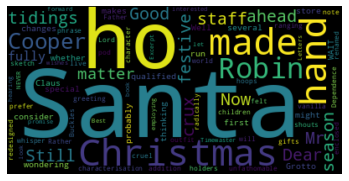

In [186]:
word_cloud=WordCloud().generate(email_body)
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [187]:
example_corpus=nltk.corpus.gutenberg.words('melville-moby_dick.txt')
len(example_corpus)

260819

In [188]:
type(example_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

In [189]:
word_list=[''.join(word) for word in example_corpus]
novel_as_string=''.join(word_list)

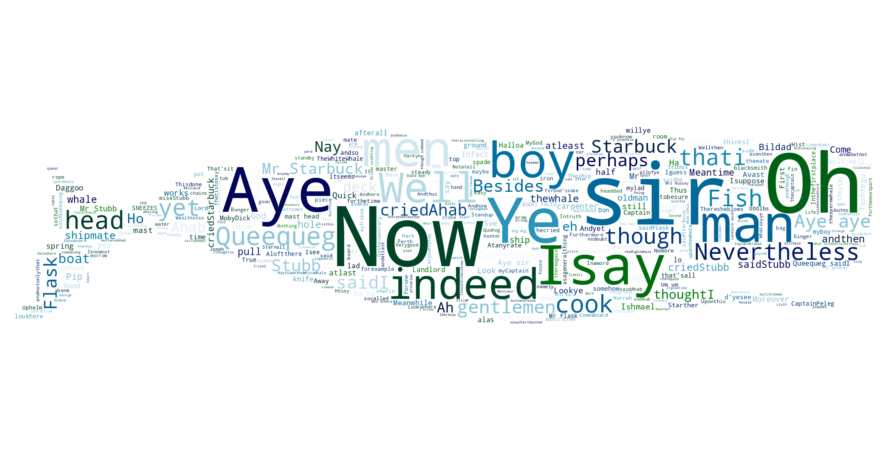

In [190]:
icon=Image.open(WHALE_FILE)
image_mask=Image.new(mode='RGB',size=icon.size,color=(255,255,255))
image_mask.paste(icon,box=icon)

rgb_array=np.array(image_mask) #Converts the image obj to array

word_cloud=WordCloud(mask=rgb_array,background_color='white',
                     max_words=400,colormap='ocean')
word_cloud.generate(novel_as_string)

plt.figure(figsize=[16,8])
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [191]:
rgb_array.shape


(1024, 2048, 3)

In [192]:
hamlet_corpus=nltk.corpus.shakespeare.words('hamlet.xml')
len(hamlet_corpus)

40379

In [193]:
hamlet_word=''.join(hamlet_corpus)

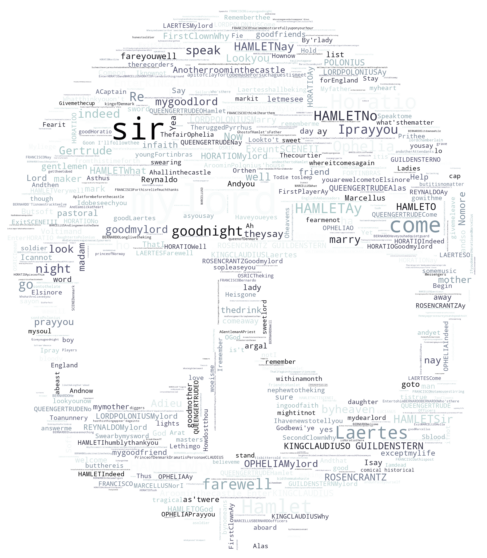

In [194]:
icon_skull=Image.open(SKULL_FILE)
image_mask=Image.new(mode='RGB',size=icon_skull.size,color=(255,255,255)
                    )
image_mask.paste(icon_skull,box=icon_skull)

rgb_array=np.array(image_mask)

word_cloud=WordCloud(mask=rgb_array,background_color='white',
                     max_words=600,colormap='bone')
word_cloud.generate(hamlet_word)

plt.figure(figsize=[20,10])
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

# Email wordcloud

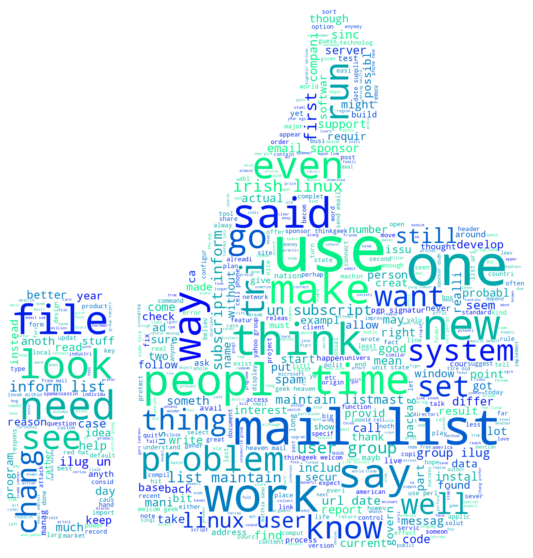

In [195]:
ham_str=' '.join(flat_list_ham)

icon_skull=Image.open(HAM_ICON)
image_mask=Image.new(mode='RGB',size=icon_skull.size,color=(255,255,255)
                    )
image_mask.paste(icon_skull,box=icon_skull)

rgb_array=np.array(image_mask)

word_cloud=WordCloud(mask=rgb_array,background_color='white',
                     max_words=600,colormap='winter')
word_cloud.generate(ham_str)

plt.figure(figsize=[20,10])
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

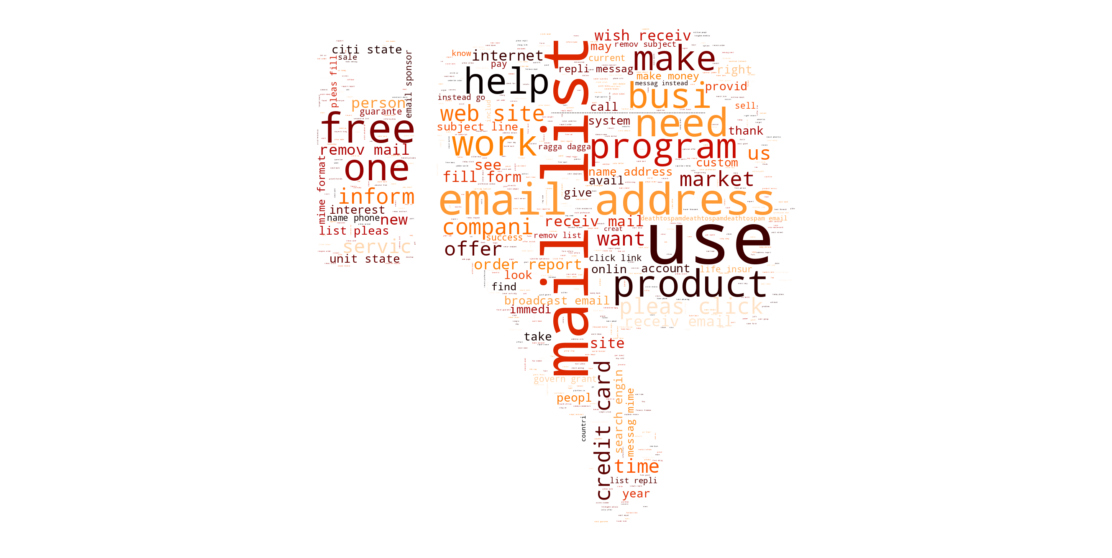

In [196]:
spam_str=' '.join(flat_list_spam)

icon_skull=Image.open(SPAM_ICON)
image_mask=Image.new(mode='RGB',size=icon_skull.size,color=(255,255,255)
                    )
image_mask.paste(icon_skull,box=icon_skull)

rgb_array=np.array(image_mask)

word_cloud=WordCloud(mask=rgb_array,background_color='white',
                     max_words=600,colormap='gist_heat')
word_cloud.generate(spam_str)

plt.figure(figsize=[20,10])
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

# Generate vocab and dict

In [208]:
stemmed_nested_list=data.MESSAGE.apply(clean_msg_no_html)

flat_stemmed_list=[item for sub in stemmed_nested_list for item in sub]

In [209]:
unique_words=pd.Series(flat_stemmed_list).value_counts()
unique_words.shape

(27422,)

In [210]:
unique_words.head()

http     10674
use       5021
list      4854
email     4371
get       4200
dtype: int64

In [211]:
frequent_words=unique_words[:VOCAB_SIZE]

In [212]:
frequent_words.head(5)

http     10674
use       5021
list      4854
email     4371
get       4200
dtype: int64

## Create vocab df with WORD_ID

In [213]:
word_ids=list(range(0,VOCAB_SIZE))
vocab=pd.DataFrame({'VOCAB_WORD':frequent_words.index.values},index=word_ids)
vocab.index.name='WORD_ID'

In [214]:
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


# Save the vocab as csv

In [215]:
vocab.to_csv(WORD_ID_FILE,index_label=vocab.index.name,header=vocab.VOCAB_WORD.name)

In [216]:
sample_list=['machine','learning','fun','learn','data','science','app','brewery']

any(vocab.VOCAB_WORD == 'data')
    

True

In [217]:
 in set(vocab.VOCAB_WORD)

SyntaxError: invalid syntax (<ipython-input-217-c38c3b95f018>, line 1)

In [ ]:
data.MESSAGE.shape

In [ ]:
clean_email_len=[]
for sub in stemmed_nested_list:
    clean_email_len.append(len(sub))

In [ ]:
clean_email_len=[len(sub) for sub in stemmed_nested_list]

In [ ]:
max(clean_email_len)

In [ ]:
np.argmax(clean_email_len)

In [ ]:
data.at[4418,'MESSAGE']

# Generating  features and sparse matrix
## Creatinf df with one word per col

In [221]:
word_col_df=pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_col_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,delight,garden,ornament,combin,finest,craftsmanship,woodwork,lastest,technolog,paint,...,None,None,None,None,None,None,None,None,None,None
1,guarante,signup,ever,pay,penni,show,green,ever,take,wallet,...,None,None,None,None,None,None,None,None,None,None
2,email,market,work,way,around,medium,let,share,offer,peopl,...,None,None,None,None,None,None,None,None,None,None
3,lowest,rate,avail,term,life,insur,take,moment,fill,onlin,...,None,None,None,None,None,None,None,None,None,None
4,offic,egnr,femi,daniel,feder,ministri,work,hous,feder,secretariat,...,None,None,None,None,None,None,None,None,None,None


## Splitting the data into training and testing

In [222]:
 X_train, X_test, y_train, y_test = train_test_split(word_col_df, data.CATEGORY, test_size=0.3, random_state=42)

In [223]:
X_train.shape[0]/word_col_df.shape[0]

0.6999654934437544

In [224]:
X_train.index.name=X_test.index.name='DOC_ID'

In [225]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,hi,post,question,list,thought,updat,thank,suggest,well,decid,...,None,None,None,None,None,None,None,None,None,None
4727,tue,aug,wintermut,wrote,far,know,linux,kernel,hacker,distro,...,None,None,None,None,None,None,None,None,None,None
5022,hi,post,question,list,thought,updat,thank,suggest,well,decid,...,None,None,None,None,None,None,None,None,None,None
3504,origin,messag,john,hall,take,list,richest,countri,take,list,...,None,None,None,None,None,None,None,None,None,None
3921,paul,jakma,wrote,tue,aug,david,neari,wrote,actual,follow,...,None,None,None,None,None,None,None,None,None,None


In [226]:
y_train.head()

DOC_ID
4844    0
4727    0
5022    0
3504    0
3921    0
Name: CATEGORY, dtype: int64

### create sparse matrix for training data

In [227]:
word_index=pd.Index(vocab.VOCAB_WORD)
word_index.get_loc('thu')

394

In [228]:
X_train.index[0]

4844

In [229]:
len(set(vocab.VOCAB_WORD))

2500

In [230]:
def make_sparse_matrix(df,indexed_words,labels):
    """
    Returns sparse matrix as df.
    
    df:A df with words in the cols with a doc id as an index(X_train or X_test)
    indexed_words:index of words ordered by word id
    labels: category as a series(y_train or y_test)
    """
    nr_rows=df.shape[0]
    nr_cols=df.shape[1]
    word_set=set(indexed_words)
    dict_list=[]
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word=df.iat[i,j]
            if word in word_set:
                doc_id=df.index[i]
                word_id=indexed_words.get_loc(word)
                category=labels.at[doc_id]
                
                item={'LABEL':category,'DOC_ID':doc_id,'OCCURENCE':1,'WORD_ID':word_id}
                
                dict_list.append(item)
    
    return pd.DataFrame(dict_list)
    
    

In [231]:
%%time
sparse_train_df=make_sparse_matrix(X_train,word_index,y_train)

CPU times: user 3min 2s, sys: 186 ms, total: 3min 3s
Wall time: 3min 3s


In [232]:
sparse_train_df.tail()

,LABEL,DOC_ID,OCCURENCE,WORD_ID
445001,1,860,1,10
445002,1,860,1,260
445003,1,860,1,28
445004,1,860,1,0
445005,1,860,1,212


### cmbine occurences with pandas groupby()

In [233]:
train_grouped=sparse_train_df.groupby(['DOC_ID','WORD_ID','LABEL']).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      0       1              2
       2       1              1
       16      1              2
       17      1              1
       18      1              2

In [234]:
train_grouped=train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,0,1,2
1,0,2,1,1
2,0,16,1,2
3,0,17,1,1
4,0,18,1,2


In [235]:
train_grouped.shape

(265601, 4)

## Save trining data as .txt file

In [ ]:
np.savetxt(TRAINING_DATA_FILE,train_grouped,fmt='%d')

In [236]:
train_grouped.columns

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'OCCURENCE'], dtype='object')

### creating sparse matric for testing data

In [237]:
%%time
sparse_test_df=make_sparse_matrix(X_test,word_index,y_test)

CPU times: user 1min 23s, sys: 55.1 ms, total: 1min 23s
Wall time: 1min 23s


In [240]:
sparse_test_df.head()

,LABEL,DOC_ID,OCCURENCE,WORD_ID
0,0,4675,1,744
1,0,4675,1,495
2,0,4675,1,1176
3,0,4675,1,36
4,0,4675,1,419


In [249]:
test_grouped=sparse_test_df.groupby(['DOC_ID','WORD_ID','LABEL']).sum()
test_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
8      0       1              2
       1       1              5
       2       1              1
       3       1              2
       10      1              3

In [250]:
test_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
8      0       1              2
       1       1              5
       2       1              1
       3       1              2
       10      1              3

In [251]:
test_grouped=test_grouped.reset_index()

In [252]:
test_grouped.shape

(111007, 4)

In [253]:
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,8,0,1,2
1,8,1,1,5
2,8,2,1,1
3,8,3,1,2
4,8,10,1,3


In [257]:
np.savetxt(TESTING_DATA_FILE,test_grouped,fmt='%d')

In [255]:
test_grouped.columns

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'OCCURENCE'], dtype='object')

## Checkpoints and observations

In [258]:
train_doc_ids=set(train_grouped.DOC_ID)
test_doc_ids=set(test_grouped.DOC_ID)


In [259]:
len(test_doc_ids)

1717

In [260]:
len(X_test)

1739

In [263]:
set(X_test.index.values)-test_doc_ids

{65,
 71,
 121,
 151,
 247,
 263,
 286,
 296,
 325,
 334,
 452,
 497,
 654,
 744,
 798,
 1029,
 1047,
 1144,
 1200,
 1334,
 1471,
 1665}

In [267]:
data.MESSAGE[65]

'------=_NextPart_000_00E4_17A73C2D.E7104E07\n\nContent-Type: text/plain; charset="iso-8859-1"\n\nContent-Transfer-Encoding: base64\n\n\n\n\n\nSGVyZSdzIHRoZSBob3R0ZXN0IHRoaW5nIGluIERWRHMuIE5vdyB5b3UgY2Fu\n\nIG1ha2UgYSBwZXJzb25hbCBiYWNrdXANCmNvcHkgb2YgYSBEVkQgcmlnaHQg\n\nb250byBDRC1SLiAgT3VyICJIb3QiIG5ldyBzb2Z0d2FyZSBlYXNpbHkgdGFr\n\nZXMgeW91IHRocm91Z2gNCnRoZSBzdGVwcyB0byBtYWtlIGEgY29weSBvZiB5\n\nb3VyIG93biBEVkRzLg0KDQpOT1cgSU5DTFVERUQgRk9SIEZSRUUhIENvcHkg\n\nUExBWVNUQVRJT04sIE1VU0lDL01QM3MgYW5kIGFsbCBTb2Z0d2FyZS4NCg0K\n\nLSBTdGVwIGJ5IFN0ZXAgSW50ZXJhY3RpdmUgSW5zdHJ1Y3Rpb25zIA0KLSBB\n\nbGwgU29mdHdhcmUgVG9vbHMgSW5jbHVkZWQgT24gQ0QgDQotIE5vIERWRCBC\n\ndXJuZXIgUmVxdWlyZWQgDQotIEZSRUUgTGl2ZSBUZWNobmljYWwgU3VwcG9y\n\ndCANCi0gMzAgRGF5IFJpc2sgRnJlZSBUcmlhbCBBdmFpbGFibGUgDQotIEZS\n\nRUUgRHZkIE1vdmllIG9mIHlvdXIgY2hvaWNlIChMSU1JVEVEIFRJTUUgT0ZG\n\nRVIhKQ0KDQpXZSBoYXZlIEFsbCB0aGUgc29mdHdhcmUgeW91IG5lZWQgdG8g\n\nQ09QWSB5b3VyIG93biBEVkQgTW92aWVzLg0KDQpodHRwOi8vZHZkLnNwZWNp\n\nYWxkaXNjb3VudHM0dS5jb20vD

In [268]:
data.loc[14]

MESSAGE      This is a multi-part message in MIME format.\n...
CATEGORY                                                     1
FILE_NAME               00239.2f1370f9cba5ab21297eadb2af40b051
Name: 14, dtype: object

In [270]:
clean_msg_no_html(data.at[65,'MESSAGE'])

['kysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysr',
 'kysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysr']